# Importing libraries

Files need to be saved on Google Drive



In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting Tensorflow Dataset objects
Load images to train, test, validate Dataset objects and make DataFrameIterator generator object from them 

In [ ]:
def split(data, train_size=0.6, test_size=0.2, validate_size=0.2):
	train, test = train_test_split(data, test_size=test_size)
 	# calculate ratio of validation set and what's left after separating test set
	validate_ratio = validate_size / (train_size + validate_size)
	train, validate = train_test_split(train, test_size=validate_ratio)
	return train, test, validate

In [ ]:
# get dataframe object
df = pd.read_csv('/content/drive/My Drive/Soda_Bottles/full.csv')

train, test, validate = split(df)

# https://stackoverflow.com/questions/63761717/load-image-dataset
# Data augmentation pipeline
# using normalization, rotation for 90 degrees, shifting 20% on any side, changing brightness by 0.5 up or down, and zooming in or out 30%
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=90, width_shift_range=0.2, height_shift_range=0.2, brightness_range=(0.5, 1.5), zoom_range=0.3)
# test and validate have only normalization
test_validate_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# default image shape is (256, 256)
train_ds = train_datagen.flow_from_dataframe(train, directory='/content/drive/My Drive/Soda_Bottles/', x_col='Path', y_col='Label')
test_ds = test_validate_datagen.flow_from_dataframe(test, directory='/content/drive/My Drive/Soda_Bottles/', x_col='Path', y_col='Label')
validate_ds = test_validate_datagen.flow_from_dataframe(validate, directory='/content/drive/My Drive/Soda_Bottles/', x_col='Path', y_col='Label')

Found 3969 validated image filenames belonging to 8 classes.
Found 1323 validated image filenames belonging to 8 classes.
Found 1323 validated image filenames belonging to 8 classes.


# Define architecture and train custom model

Will be using basic Convolution-Pooling-Fully connected architecture

In [ ]:
# stack of layers
model = tf.keras.models.Sequential()
# 32 feature maps made with 5x5 kernel over input image
model.add(tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(256, 256, 3)))
# pooling to reduce dimensions in half, left with 126x126x32
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
# dimensionality reduction, getting 32 feature maps from those 64 from previous conv layer
# combats overfitting and reduces number of parameters
model.add(tf.keras.layers.Conv2D(32, (1,1), activation='relu'))
# pooling to reduce dimensions in half, left with 62x62x32
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
# drops 30% of weights to 0, used for overfitting reduction
model.add(tf.keras.layers.Dropout(0.3))
# fully connected layer that makes sense of the features extracted by previous layers
model.add(tf.keras.layers.Dense(128, activation='relu'))
# softmax layer for classification
model.add(tf.keras.layers.Dense(8, activation='softmax'))

# stop when validation loss doesn't decrease more than 0.01 in 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dropout (Dropout)            (None, 123008)            0

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds, epochs=40, validation_data=validate_ds, callbacks=[callback])
# accidentaly ran the cell again and lost output :(
# trained for ~25 epochs
# test -> loss: 0.2549, accuracy: 0.9184
model.evaluate(test_ds)

In [ ]:
# save good enough model
model.save('/content/drive/My Drive/custom_model_2')

# Transfer learning
I'll be using InceptionV3 because it has good accuracies with acceptable number of parameters https://keras.io/api/applications/

It will be used as a feature extractor -> only the convolutional base will be used on top of which a new classifier will be trained.

After that it will be fine tuned -> some of the convolutional layers will also be trained

In [ ]:
# https://paperswithcode.com/method/inception-v3
inception_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(256,256,3), pooling='avg')
# freezing the convolutional base
inception_model.trainable = False
# define one more fully connected layer
fcl_layer = tf.keras.layers.Dense(512, activation='relu')
# define classification layer
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
# define preprocessing layer which rescales pixels to [-1,1]
preprocess_data = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
# build a model
# input layer
inputs = tf.keras.Input(shape=(256, 256, 3))
# layer with inception preprocessing
x = preprocess_data(inputs)
# inception convolutional base
x = inception_model(x)
# fully connected layer
x = fcl_layer(x)
# dropping weights to 0
x = tf.keras.layers.Dropout(0.3)(x)
# classification, softmax layer
outputs = prediction_layer(x)
# put all of that together
tl_model = tf.keras.Model(inputs, outputs)

tl_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

tl_model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_16 (TFOpLamb (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract_16 (TFOpLam (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_19 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 410

In [ ]:
history = tl_model.fit(train_ds, epochs=8, validation_data=validate_ds)

tl_model.evaluate(test_ds)

Epoch 1/8
125/125 [==============================] - 119s 914ms/step - loss: 2.1517 - accuracy: 0.3100 - val_loss: 1.1695 - val_accuracy: 0.5193
Epoch 2/8
125/125 [==============================] - 112s 896ms/step - loss: 1.1198 - accuracy: 0.5464 - val_loss: 0.9879 - val_accuracy: 0.6168
Epoch 3/8
125/125 [==============================] - 111s 884ms/step - loss: 1.0460 - accuracy: 0.5500 - val_loss: 0.8719 - val_accuracy: 0.6659
Epoch 4/8
125/125 [==============================] - 110s 880ms/step - loss: 0.9280 - accuracy: 0.6148 - val_loss: 0.8833 - val_accuracy: 0.6206
Epoch 5/8
125/125 [==============================] - 111s 885ms/step - loss: 0.8498 - accuracy: 0.6344 - val_loss: 0.7638 - val_accuracy: 0.6704
Epoch 6/8
125/125 [==============================] - 110s 882ms/step - loss: 0.8222 - accuracy: 0.6508 - val_loss: 0.6510 - val_accuracy: 0.7370
Epoch 7/8
125/125 [==============================] - 111s 887ms/step - loss: 0.8034 - accuracy: 0.6770 - val_loss: 0.7028 - val_ac

[0.637934148311615, 0.7241118550300598]

In [ ]:
# test -> loss: 0.6379, acc: 0.7241
# fine tune it
inception_model.trainable = True

print("Number of layers:", len(inception_model.layers)) # 312

# Freeze all the layers before the 212th layer
for layer in inception_model.layers[:212]:
  layer.trainable =  False

tl_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Number of layers: 312


In [ ]:
tl_model.fit(train_ds,epochs=12, initial_epoch=history.epoch[-1], validation_data=validate_ds)

tl_model.evaluate(test_ds) # loss: 0.2512, accuracy: 0.9116

Epoch 8/12
125/125 [==============================] - 124s 931ms/step - loss: 0.7641 - accuracy: 0.6944 - val_loss: 1.7632 - val_accuracy: 0.6795
Epoch 9/12
125/125 [==============================] - 114s 911ms/step - loss: 0.3025 - accuracy: 0.8678 - val_loss: 0.1855 - val_accuracy: 0.9282
Epoch 10/12
125/125 [==============================] - 114s 908ms/step - loss: 0.2544 - accuracy: 0.8938 - val_loss: 0.2957 - val_accuracy: 0.8776
Epoch 11/12
125/125 [==============================] - 114s 911ms/step - loss: 0.2471 - accuracy: 0.9041 - val_loss: 0.1594 - val_accuracy: 0.9410
Epoch 12/12
42/42 [==============================] - 12s 278ms/step - loss: 0.2512 - accuracy: 0.9116


[0.2511530816555023, 0.9115646481513977]

In [ ]:
tl_model.save('/content/drive/My Drive/tl_model_1')

INFO:tensorflow:Assets written to: /content/drive/My Drive/tl_model_1/assets


Before comparing metrics I need to comment on logistics of two approaches.

Selecting architecture was obviously easier for Transfer learning. I just looked at available models in Tensorflow and chose the one I found most suited. Criteria was best accuracy and lowest number of parameters. For custom approach I started with something I thought would be good enough and, with a lot of trail and error, came to the acceptable result.

Training is also a category in which Transfer learning wins. In just 8 epoch top fully connected layer was trained and in 4 more epochs of fine tuning top 100 layers got to 90+% validation accuracy. Each epoch took slightly longer than with custom model, 90s vs 120s, but 12 vs 25 epochs is a big difference.

Number of parameters is only category in which custom beats transfer: 15.8 million vs 22.9 million.

# Metrics

Comparing resulting metrics of both approaches

In [ ]:
# load the models
model = tf.keras.models.load_model('/content/drive/My Drive/custom_model_2')
tl_model = tf.keras.models.load_model('/content/drive/My Drive/tl_model_1')

In [ ]:
import numpy as np
# combine test and validate sets for calculating metrics
# numpy matrix of images
metrics_X = np.empty(shape=(2646, 256, 256, 3))
# numpy matrix of one hot encoded labels
metrics_y = np.empty(shape=(2646, 8))

# fill them up
print('Test set')
counter = 0

for img, lbl in test_ds:
  # batch of 32
  print(counter)
  if counter >= 1323:
    # got to explicitly tell to stop or iterates indefinitely
    break
  for img_, lbl_ in zip(img, lbl):
    metrics_X[counter] = img_
    metrics_y[counter] = lbl_
    counter +=1

print('Validate set')
for img, lbl in validate_ds:
  # batch of 32
  print(counter)
  if counter >= 2646:
    break
  for img_, lbl_ in zip(img, lbl):
    metrics_X[counter] = img_
    metrics_y[counter] = lbl_
    counter +=1

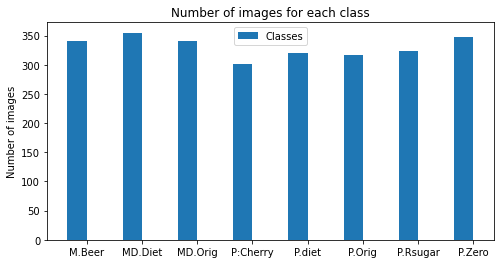

In [ ]:
# plot classes
import matplotlib.pyplot as plt

labels = ['M.Beer', 'MD.Diet', 'MD.Orig', 'P:Cherry', 'P.diet', 'P.Orig', 'P.Rsugar', 'P.Zero']
n, counts = np.unique(metrics_y, return_counts=True)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x - width/2, counts, width, label='Classes')

ax.set_ylabel('Number of images')
ax.set_title('Number of images for each class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

Biggest difference is between MD.Diet and P.Cherry, 54 images, but mostly the classes are evenly split

In [ ]:
# get predictions
model_pred = model.predict(metrics_X)
tl_model_pred = tl_model.predict(metrics_X)

# free the RAM after getting predictions
del metrics_X

Real labels are saved in a $2646\times 8$ numpy matrix _metrics_y_

_model_pred_ and _tl_model_pred_ are $2646\times 8$ numpy matrices of predictions from each model

For sklearn we need them in integer form, not one hot encoded

In [ ]:
# perform one hot to integer label conversion
metrics_y = np.argmax(metrics_y, axis=1)
model_pred = np.argmax(model_pred, axis=1)
tl_model_pred = np.argmax(tl_model_pred, axis=1)

In [ ]:
from sklearn.metrics import classification_report
# returns dict with F1 score, precision and recall for each class
# also overall accuracy, macro average f1, precision and recall, and weighted average f1, precision and recall
model_dict = classification_report(metrics_y, model_pred, output_dict=True, 
  target_names=['M.Beer', 'MD.Diet', 'MD.Orig', 'P:Cherry', 'P.diet', 'P.Orig', 'P.Rsugar', 'P.Zero'])

tl_model_dict = classification_report(metrics_y, tl_model_pred, output_dict=True, 
  target_names=['M.Beer', 'MD.Diet', 'MD.Orig', 'P:Cherry', 'P.diet', 'P.Orig', 'P.Rsugar', 'P.Zero'])

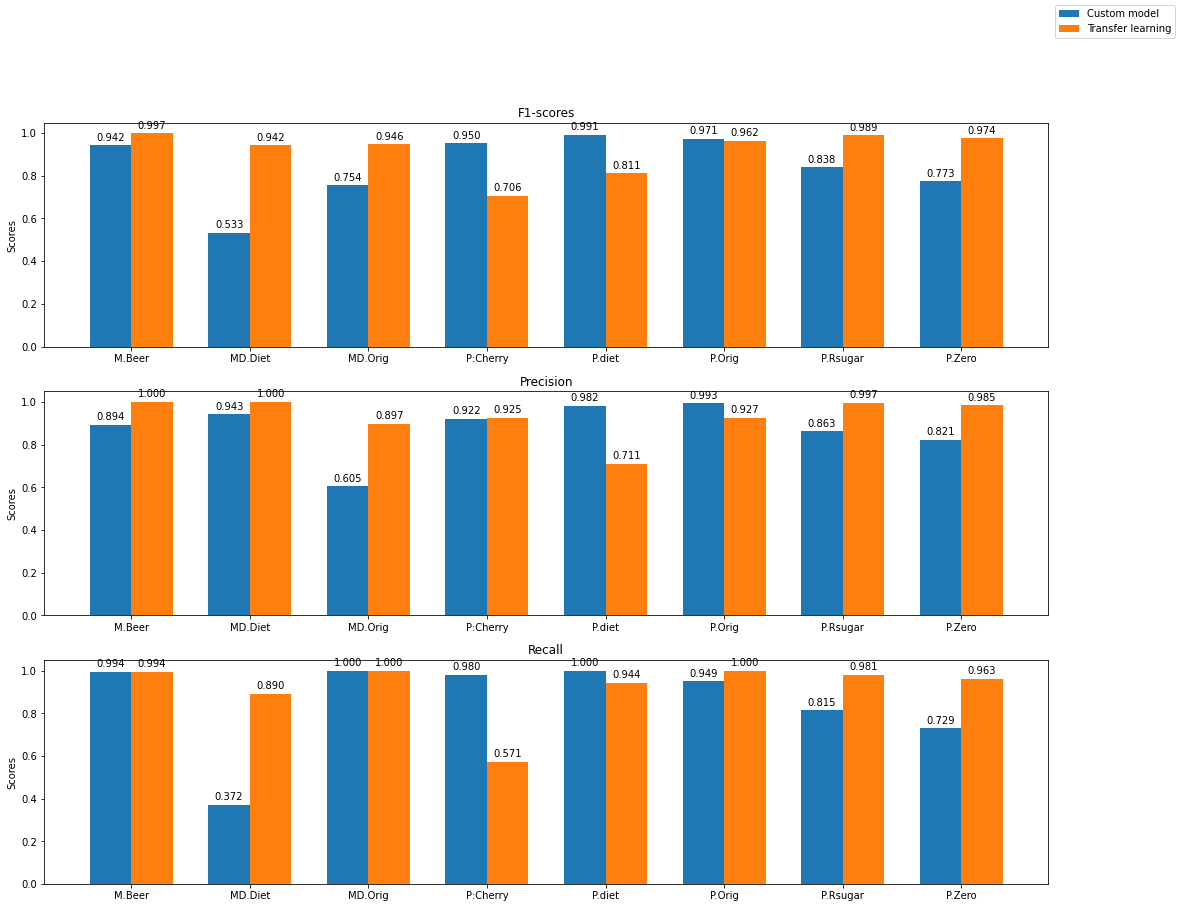

In [ ]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

# list with values for f1-score, precision, and recall respectively
model_results = [[], [], []]
tl_results = [[], [], []]

for k in labels:
    model_results[0].append(model_dict[k]['f1-score'])
    tl_results[0].append(tl_model_dict[k]['f1-score'])

    model_results[1].append(model_dict[k]['precision'])
    tl_results[1].append(tl_model_dict[k]['precision'])

    model_results[2].append(model_dict[k]['recall'])
    tl_results[2].append(tl_model_dict[k]['recall'])

def autolabel(rects, ax_):
    """Attach a text label above each bar in *rects* on subplot *ax_*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots(3, 1, figsize=(18,14))
for i in range(3):
  rect1 = ax[i].bar(x - width/2, model_results[i], width)
  rect2 = ax[i].bar(x + width/2, tl_results[i], width)
  ax[i].set_ylabel('Scores')
  ax[i].set_xticks(x)
  ax[i].set_xticklabels(labels)
  autolabel(rect1, ax[i])
  autolabel(rect2, ax[i])

fig.legend(['Custom model', 'Transfer learning'])
ax[0].set_title('F1-scores')
ax[1].set_title('Precision')
ax[2].set_title('Recall')

plt.show()

F1-score is [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of Precision and Recall. It rewards (higher score) models which have similar Precision and Recall.

Precision is ratio of correct true predictions in all true predicted.

Recall is ratio of correct true predictions in all true examples.

Transfer learning model has better F1-scores for 5/8 classes, which is partly expected. The worst result is on the least represented class.

Custom model has better F1-scores for 3/8 classes. Worst result is on the most represented class.

Lowest Transfer learning values are still higher than Custom model.

In [ ]:
# list with values for accuracy, macro avg f1, precision and recall, and weighted avg f1, precision and recall
print("Custom model end accuracy: {:.2f}% vs Transfer learning end accuracy: {:.2f}%".format(model_dict['accuracy']*100, tl_model_dict['accuracy']*100))

for k in ['macro avg', 'weighted avg']:
  print(k)
  print("My model: f1-score: {:.4f}, precision: {:.4f}, recall: {:.4f}".format(model_dict[k]['f1-score'], model_dict[k]['precision'], model_dict[k]['recall']))
  print("TL model: f1-score: {:.4f}, precision: {:.4f}, recall: {:.4f}".format(tl_model_dict[k]['f1-score'], tl_model_dict[k]['precision'], tl_model_dict[k]['recall']))

Custom model end accuracy: 84.85% vs Transfer learning end accuracy: 92.18%
macro avg
My model: f1-score: 0.8439, precision: 0.8779, recall: 0.8549
TL model: f1-score: 0.9159, precision: 0.9303, recall: 0.9180
weighted avg
My model: f1-score: 0.8382, precision: 0.8756, recall: 0.8485
TL model: f1-score: 0.9192, precision: 0.9321, recall: 0.9218


Transfer learning approach has higher overall accuracy, which was expected because it is a complex and more expressive network. 

Both models have pretty even macro and weighted metrics which proves that the dataset is balanced. Transfer model still beats Custom in every metric.


# Closing words

Transfer learning has it's drawbacks, but, with todays libraries like Tensorflow and Pytorch, it's a good approach for any project that just aims for end result. Those models require less training and less knowledge of how they work.

But making custom architecture is more satisfying and has more learning potential by making you think about why each layer is where it is.